In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as p

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [85]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [86]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [87]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [88]:
# We can view all of the classes that automap found
print(Base.classes.keys())


['measurement', 'station']


In [89]:
inspector = inspect(engine)
print(inspector.get_columns('measurement'))
print(inspector.get_columns('station'))

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 

In [90]:
# Save references to each table
stations = Base.classes.station
measurement = Base.classes.measurement

In [91]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-23 00:00:00
[('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08), ('2016-08-25', 0.08), ('2016-08-25', 0.0)]
            precipitation
date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.22


<AxesSubplot:xlabel='date'>

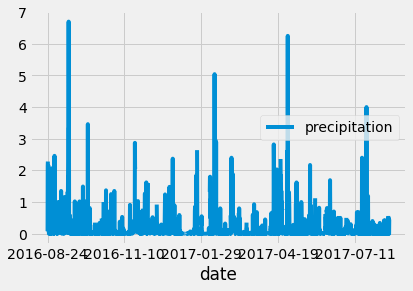

In [92]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
last_date = [row[2] for row in session.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 1')]
last_entry_db = last_date[0].split('-')
year = int(last_entry_db[0])
month = int(last_entry_db[1])
day = int(last_entry_db[2])
last_date_db = dt.datetime(year, month, day)
print(last_date_db)
# Calculate the date one year from the last date in data set.
prev_year = last_date_db - dt.timedelta(days = 365)
print(prev_year)
# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prev_year).order_by(measurement.date).all()
print(results[:10])
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(data = results, columns = ['date','precipitation']).set_index('date')

# Sort the dataframe by date
prcp_df.sort_values('date',inplace = True)
print(prcp_df.head())
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [101]:
# How many stations are available in this dataset?
session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).all()

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [97]:
# What are the most active stations?
session.query(measurement.station,
              func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.tobs).desc()).all()
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [104]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(measurement.station,func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

            temperature
date                   
2016-08-24         77.0
2016-08-25         80.0
2016-08-26         80.0
2016-08-27         75.0
2016-08-28         73.0


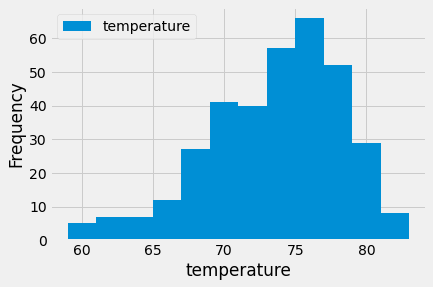

In [157]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = []
results = session.query(measurement.date,measurement.tobs).filter((measurement.date >= prev_year) & (measurement.station == 'USC00519281')).all()
high_station_12_mon_df = pd.DataFrame(results,columns = ['date','temperature'])
high_station_12_mon_df.set_index('date',inplace = True)
print(high_station_12_mon_df.head())
high_station_12_mon_df.plot.hist(bins = 12)
plt.xlabel('temperature')
plt.tight_layout
plt.show()

In [231]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps (start_date = str, end_date = str):
    start_date = start_date.split('-')
    start_year = int(start_date[0])
    start_month = int(start_date[1])
    start_day = int(start_date[2])
    start_dt = dt.datetime(start_year,start_month,start_day)
    end_date = end_date.split('-')
    end_year = int(end_date[0])
    end_month = int(end_date[1])
    end_day = int(end_date[2])
    result = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.date >= (dt.datetime(start_year,start_month,start_day))).filter(measurement.date <= (dt.datetime(end_year,end_month,end_day))).all()
    min_temp = result[0][0]
    max_temp = result[0][1]
    average_temp = result[0][2]
    return min_temp, max_temp, average_temp

                           
                

In [232]:
calc_temps('2016-1-21','2017-8-31')

2016


(56.0, 87.0, 74.30820770519263)

# Challenge